In [25]:
import os
from datetime import datetime
import itertools
import numpy as np
import pandas as pd
import pandas_profiling
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#------------ CONFIG ------------#
gridsearch  = False
eda         = False
#--------------------------------#

In [3]:
input_folder = "./data"
output_folder = "./results"
profiles_folder = "./profiles"
train = pd.read_csv(f"{input_folder}/train.csv")
test = pd.read_csv(f"{input_folder}/test.csv")
seed = 2020

In [4]:
if eda:
    trainprofile = train.profile_report(title='Train Profiling Report', plot={'histogram': {'bins': 8}})
    trainprofile.to_file(output_file=f"{profiles_folder}/train_profiling.html")
    testprofile = test.profile_report(title='Test Profiling Report', plot={'histogram': {'bins': 8}})
    testprofile.to_file(output_file=f"{profiles_folder}/test_profiling.html")

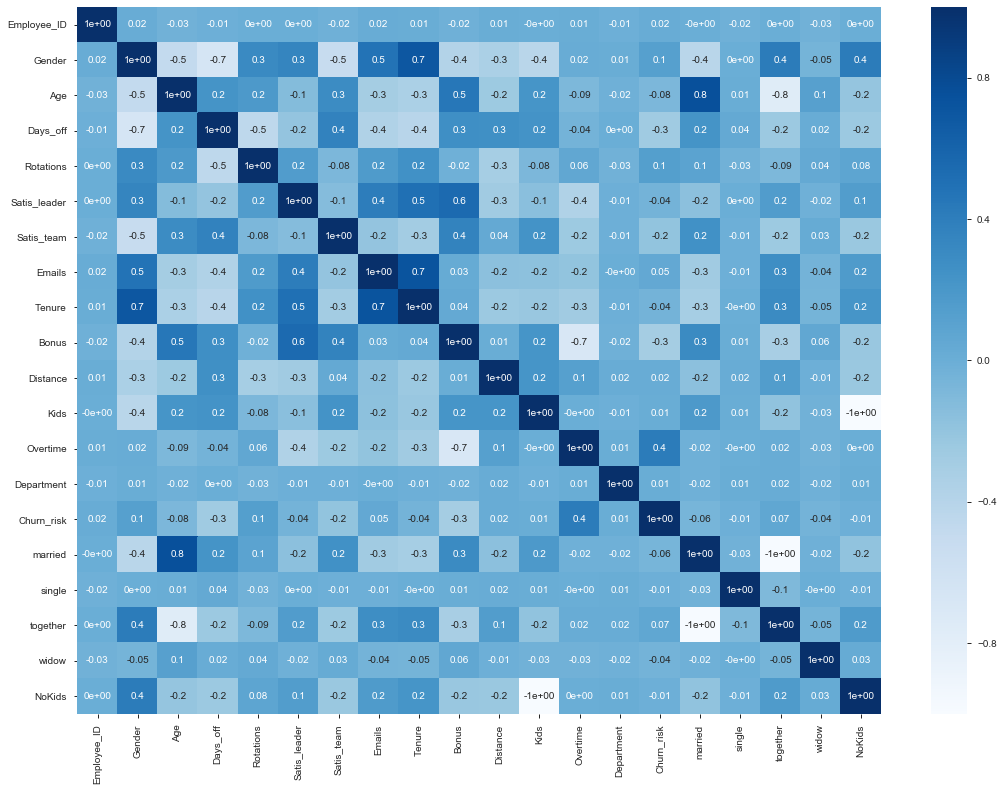

In [45]:
def cor_heatmap(cor):
    plt.figure(figsize=(18,13))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.1')
    plt.ylim(plt.ylim()[0] + 0.5, plt.ylim()[1] - 0.5)
    plt.show()

cor_heatmap(train.corr().round(2))

Encoding categorical variables:

In [6]:
churn_risk_dict = {"low": 0, "medium": 1, "high": 2}
train["Churn_risk"] = train["Churn_risk"].map(churn_risk_dict)


oe = OrdinalEncoder()
train["Department"] = oe.fit_transform(np.array(train["Department"]).reshape(-1, 1))
test["Department"] = oe.transform(np.array(test["Department"]).reshape(-1, 1))
train["Gender"] = oe.fit_transform(np.array(train["Gender"]).reshape(-1, 1))
test["Gender"] = oe.transform(np.array(test["Gender"]).reshape(-1, 1))


train = pd.concat([train.drop("Marital_status", axis=1), pd.get_dummies(train["Marital_status"])], axis=1)
test = pd.concat([test.drop("Marital_status", axis=1), pd.get_dummies(test["Marital_status"])], axis=1)

Creating new features:

In [7]:
# train["NoKids"] = (train["Kids"] == 0)
# test["NoKids"] = (test["Kids"] == 0)

Creating train data:

In [8]:
target = "Churn_risk"

X = train.drop(["Employee_ID", target], axis=1)
y = train[target]

useful_cols = X.columns

Dealing with missing values:

In [9]:
# from sklearn.impute import KNNImputer
from missingpy import KNNImputer # Exactly the same as line above
# Couldn't upgrade scikit-learn due to missing admin permissions of company's laptop during COVID-19 quarantine.

imputer = KNNImputer()
X = imputer.fit_transform(X)
X = pd.DataFrame(X, columns=useful_cols)

test_ids = test["Employee_ID"]
test = imputer.transform(test.drop("Employee_ID", axis=1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\missingpy\utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: Deprecati

Scaling our data:

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=useful_cols)

Training Naive Bayes:

In [51]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

clf = MultinomialNB(fit_prior=True)

# clf = GaussianNB()
clf.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Evaluate the model:

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit, KFold

def run_kfold(clf):
    sss = StratifiedShuffleSplit(n_splits=2000, test_size=0.25, random_state=2020)
#     sss = StratifiedShuffleSplit(n_splits=2000, test_size=0.25, random_state=2020)
    outcomes = []
    fold = 0
    for train_indices, test_indices in sss.split(X, y):
        fold += 1
        X_train, X_test = X.values[train_indices], X.values[test_indices]
        y_train, y_test = y.values[train_indices], y.values[test_indices]
        
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        # model.predict_proba(scaler.transform(test))
        
        f1 = f1_score(y_test, predictions, average="micro")
        outcomes.append(f1)

    mean_outcome = np.mean(outcomes)
    print(f"# of Folds: {fold}")
    print(f"Mean F1-Score: {mean_outcome}") 

run_kfold(clf)


# X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.25, stratify = target, random_state=5)

# of Folds: 2000
Mean F1-Score: 0.6055911538461539


Making predictions:

In [19]:
preds = clf.predict(scaler.transform(test))
pd.Series(preds).value_counts()

1    1178
2     100
0      22
dtype: int64

Reversing `Churn_risk` encoding:

In [20]:
reverse_churn_risk_dict = {}

for key, value in churn_risk_dict.items():
    reverse_churn_risk_dict[value] = key

preds = pd.Series(preds).map(reverse_churn_risk_dict)

Lazy get submission version:

In [21]:
def find_version():
    """
    Finds automatically the version of the submission. :)
    """
    version = 1
    if len(os.listdir("results")) > 0:
        for file in os.listdir("results"):
            if file.split("_")[1].startswith("version"):
                if int(file.split("_")[1].split("n")[1].split(".")[0]) > version:
                    version = int(file.split("_")[1].split("n")[1].split(".")[0])
        return version + 1
    else:
        return version

Writing submission:

In [22]:
output = pd.DataFrame({"Employee_ID": test_ids, "Churn_risk": preds})
output.to_csv(f'{output_folder}/m20180428_version{find_version()}.csv', index = False)
output.head()

,Employee_ID,Churn_risk
0,1005201,medium
1,1005202,medium
2,1005203,medium
3,1005204,medium
4,1005205,high


In [23]:
from datetime import datetime
print(datetime.now())

2020-04-27 02:21:18.617005


In [24]:
halt

NameError: name 'halt' is not defined

In [ ]:
preds = np.zeros((len(test_ids),))

for model in list_of_models:
    preds += model.predict_proba(scaler.transform(test))

In [ ]:
# commenting because MLPClassifier already uses Shuffle sampling and Train/Val split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [ ]:
%%time
if gridsearch:
    # control variable `gridsearch` so we don't repeat this process everytime we run the notebook
    clf = MLPClassifier(
        max_iter = 1000,
        random_state = seed,
        warm_start = True
    )

    # Choose some parameter combinations to try
    parameters = {
        'learning_rate': ["constant", "invscaling", "adaptive"],
        'hidden_layer_sizes': [(100, 50, 50), (100, 100, 100), (150, 100, 50)],
        'alpha': list(10.0 ** -np.arange(2, 8)),
        'learning_rate_init': list(np.linspace(0.00001,0.1,6)),
        'activation': ["relu", "tanh"]
    }

    # Type of scoring used to compare parameter combinations
    acc_scorer = make_scorer(accuracy_score)

    # Run the grid search
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=5, verbose=1)
    grid_obj.fit(X, y)

    # Set the clf to the best combination of parameters
    clf = grid_obj.best_estimator_

In [ ]:
# commenting because MLPClassifier already trains with different samples (`shuffle`=True)
# in all the epochs, until it converges.

# %%time

# from sklearn.model_selection import StratifiedShuffleSplit

# def run_kfold(clf):
#     kf = StratifiedShuffleSplit(n_splits=1000, test_size=0.3, random_state=seed)
#     outcomes = []
#     fold = 0
#     for train_indices, test_indices in kf.split(X, y):
#         fold += 1
#         X_train, X_test = X.values[train_indices], X.values[test_indices]
#         y_train, y_test = y.values[train_indices], y.values[test_indices]
#         clf.fit(X_train, y_train)
#         predictions = clf.predict(X_test)
#         accuracy = accuracy_score(y_test, predictions)
#         outcomes.append(accuracy)
# #         print(f"Fold {fold} accuracy: {accuracy}")
#     mean_outcome = np.mean(outcomes)
#     print(f"# of Folds: {fold}")
#     print(f"Mean Accuracy: {mean_outcome}") 

# run_kfold(clf)

Since scikit-learn's `MLPClassifier` has no `.feature_importance_` attributes, we can't use the RFE algorithm for feature selection. Then, I'll test every single combination of `n_feats` features and select the one that gets us the best score for training. <br>
<b>NOTE:</b> The MLPClassifier hyperparameters I'm using were selected from a previous GridSearch.

In [ ]:
%%time
best_loss = 1
max_feats_to_remove = 2
final_cols = X.columns

for n_feats in range(len(X.columns)-max_feats_to_remove, len(X.columns)+1):
    clf = MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
                    beta_2=0.999, early_stopping=True, epsilon=1e-08,
                    hidden_layer_sizes=(150,100,50), learning_rate='adaptive',
                    learning_rate_init=0.01, max_iter=12000, momentum=0.9,
                    n_iter_no_change=100, nesterovs_momentum=True, power_t=0.5,
                    random_state=2020, shuffle=True, solver='adam', tol=0.00001,
                    validation_fraction=0.2, verbose=False, warm_start=False)
    
    scaler = StandardScaler()
    print(f"# features: {n_feats}")
    feat_combos = list(itertools.combinations(X.columns, n_feats))
    print(f"# possible feature combinations: {len(feat_combos)}")
    
    for i, combo in enumerate(feat_combos):
        scaler.fit_transform(X)
        clf.fit(pd.DataFrame(scaler.fit_transform(X), columns=colunas)[list(combo)], y)
        if clf.loss_ < best_loss:
            best_loss = clf.loss_
            print(f"\t... best_loss: {clf.loss_}")
            
            final_scaler = scaler
            
            del final_cols
            final_cols = list(combo)
            

from datetime import datetime
print(datetime.now())

In [ ]:
X = pd.DataFrame(final_scaler.fit_transform(X[final_cols]), columns=final_cols)
X

In [ ]:
X = pd.DataFrame(final_scaler.fit_transform(X[final_cols]), columns=final_cols)

clf = MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
                    beta_2=0.999, early_stopping=True, epsilon=1e-08,
                    hidden_layer_sizes=(150,100,50), learning_rate='adaptive',
                    learning_rate_init=0.01, max_iter=12000, momentum=0.9,
                    n_iter_no_change=100, nesterovs_momentum=True, power_t=0.5,
                    random_state=2020, shuffle=True, solver='adam', tol=0.00001,
                    validation_fraction=0.2, verbose=True, warm_start=False
                   )

clf.fit(X, y)